# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** Garam Lee \
**Email:** gl2996@nyu.edu

---

### **Problem 1: Dataset Splitting**
1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

#### (1) Generalization to NEW speakers
----------------------------------
Goal:
- We want to evaluate how well the model works on speakers that never appeared
  in the training data.

Key idea:
- Split by SPEAKER, not by individual recordings.
- Each speaker must appear in exactly one of: train, validation, or test.

Example speaker-level split:
- Train speakers:       80 speakers
- Validation speakers:  10 speakers
- Test speakers:        10 speakers

Dataset construction:
- D_train = all recordings (all 5 days, all phones) from the 80 train speakers
- D_val   = all recordings from the 10 validation speakers
- D_test  = all recordings from the 10 test speakers

Why this works:
- No speaker appears in more than one split → “speaker-independent” split.
- Validation and test sets contain completely unseen speakers.
- Because each speaker records all 44 phones, every split still has all phone
  classes, so the model can be trained and evaluated reliably.



#### (2) Adding 10,000 recordings from Kilian
----------------------------------------
Now we also want:
- Good generalization to many unseen speakers (original goal).
- High performance for one specific speaker: Kilian (personalization).

Step 1 – Keep the original speaker-independent split
- Use the same 80 / 10 / 10 speaker split for the original 100 speakers:
  - D_train_speakers: all recordings from 80 speakers
  - D_val_speakers:   all recordings from 10 speakers
  - D_test_speakers:  all recordings from 10 speakers

Step 2 – Split Kilian’s 10,000 recordings separately
- Kilian_train: e.g. 8,000 recordings
- Kilian_val:   e.g. 1,000 recordings
- Kilian_test:  e.g. 1,000 recordings
- These sets contain ONLY Kilian’s recordings and are disjoint.

Step 3 – Training strategy
- Train a global, speaker-independent model on D_train_speakers.
- Use D_val_speakers to tune hyperparameters (generalization to new speakers).
- Then personalize for Kilian:
  - Initialize a “Kilian model” from the global model’s weights.
  - Fine-tune on Kilian_train (optionally mixing a small amount of D_train_speakers
    mini-batches to avoid catastrophic forgetting).
  - Use:
    * D_val_speakers to ensure performance on other speakers does not collapse.
    * Kilian_val to tune how strongly we adapt to Kilian (learning rate, number
      of fine-tuning epochs, mixing ratio, etc.).

Step 4 – Evaluation
- Generalization to new speakers:
  - Evaluate the model on D_test_speakers (10 held-out speakers).
- Performance on Kilian:
  - Evaluate the personalized model on Kilian_test.

This design:
- Preserves a clean speaker-independent split for measuring generalization.
- Adds a separate, well-defined split for Kilian, so we can measure personalization
  quality without mixing him into train/val/test of the original 100 speakers.


### **Problem 2: K-Nearest Neighbors**

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


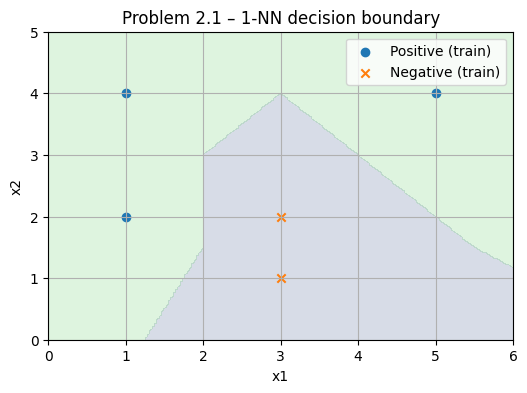

Problem 2.2 – 1-NN classification of (500,1)
Before scaling: Positive
After  scaling: Negative

Problem 2.3 – Handling missing features in a test point (K-NN)

One simple way is to compute distances only on the observed features.

Let O be the set of feature indices where the test point x has valid values.
For each training point x_i, define:

    d(x, x_i) = sqrt( sum_{j in O} (x_j - (x_i)_j)^2 )

In other words, we ignore coordinates where x is missing. Optionally we can
rescale the distance by a factor like sqrt(d_full / |O|) so that points with
fewer observed dimensions remain comparable.

Alternative approaches:
- Impute missing values (mean/median or model-based imputation) in both train
  and test data, then run standard K-NN.
- Use distance functions designed for mixed or incomplete data (e.g. Gower
  distance), which average only over observed dimensions.

The key idea is to define a distance that does not require every feature to
be present in the test point.


Problem 2.4 – 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Problem 2.1 – 1-NN decision boundary (visualization)
# ---------------------------------------------------------

# Positive and negative points
X_pos = np.array([[1, 2],
                  [1, 4],
                  [5, 4]])
X_neg = np.array([[3, 1],
                  [3, 2]])

X = np.vstack([X_pos, X_neg])
y = np.array([1, 1, 1, 0, 0])  # 1 = Positive, 0 = Negative


def predict_1nn(X_train, y_train, x_query):
    """Return the 1-NN label (0 or 1) for a single query point."""
    dists = np.linalg.norm(X_train - x_query, axis=1)
    return y_train[np.argmin(dists)]


# Create a grid over the 2D space and color by 1-NN prediction
x_min, x_max = 0, 6
y_min, y_max = 0, 5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict_1nn(X, y, p) for p in grid_points])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 4))

# Show 1-NN decision regions
plt.contourf(xx, yy, Z, alpha=0.2, levels=[-0.5, 0.5, 1.5])

# Plot training points
plt.scatter(X_pos[:, 0], X_pos[:, 1], marker="o", label="Positive (train)")
plt.scatter(X_neg[:, 0], X_neg[:, 1], marker="x", label="Negative (train)")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Problem 2.1 – 1-NN decision boundary")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------------
# Problem 2.2 – Effect of feature scaling on 1-NN
# ---------------------------------------------------------

# Given dataset
X2_pos = np.array([[100, 2],
                   [100, 4],
                   [500, 4]])
X2_neg = np.array([[300, 1],
                   [300, 2]])

X2 = np.vstack([X2_pos, X2_neg])
y2 = np.array([1, 1, 1, 0, 0])  # 1 = Positive, 0 = Negative

query = np.array([500, 1])


def dist(a, b):
    """Euclidean distance between two points."""
    return np.linalg.norm(a - b)


# (a) Before scaling
dists_before = [dist(p, query) for p in X2]
label_before = y2[np.argmin(dists_before)]  # 1 or 0


# (b) After min–max scaling to [0, 1] per feature
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min2, y_max2 = X2[:, 1].min(), X2[:, 1].max()


def minmax_scale(point, x_min, x_max, y_min, y_max):
    """Apply per-feature min–max scaling to [0, 1]."""
    return np.array([
        (point[0] - x_min) / (x_max - x_min),
        (point[1] - y_min) / (y_max - y_min),
    ])


X2_scaled = np.array([minmax_scale(p, x_min, x_max, y_min2, y_max2) for p in X2])
query_scaled = minmax_scale(query, x_min, x_max, y_min2, y_max2)

dists_after = [dist(p, query_scaled) for p in X2_scaled]
label_after = y2[np.argmin(dists_after)]

print("Problem 2.2 – 1-NN classification of (500,1)")
print("Before scaling:", "Positive" if label_before == 1 else "Negative")
print("After  scaling:", "Positive" if label_after == 1 else "Negative")


# ---------------------------------------------------------
# Problem 2.3 – Handling missing values in K-NN
# ---------------------------------------------------------

answer_2_3 = """
Problem 2.3 – Handling missing features in a test point (K-NN)

One simple way is to compute distances only on the observed features.

Let O be the set of feature indices where the test point x has valid values.
For each training point x_i, define:

    d(x, x_i) = sqrt( sum_{j in O} (x_j - (x_i)_j)^2 )

In other words, we ignore coordinates where x is missing. Optionally we can
rescale the distance by a factor like sqrt(d_full / |O|) so that points with
fewer observed dimensions remain comparable.

Alternative approaches:
- Impute missing values (mean/median or model-based imputation) in both train
  and test data, then run standard K-NN.
- Use distance functions designed for mixed or incomplete data (e.g. Gower
  distance), which average only over observed dimensions.

The key idea is to define a distance that does not require every feature to
be present in the test point.
"""

print(answer_2_3)


# ---------------------------------------------------------
# Problem 2.4 – Why can K-NN work for high-dimensional images?
# ---------------------------------------------------------

answer_2_4 = """
Problem 2.4 – Why K-NN can still work for images with many pixels

Even though images live in a very high-dimensional pixel space, K-NN can still
perform well in practice because:

1) Natural images lie on a low-dimensional manifold:
   - Real images are highly structured: only a tiny subset of all possible
     pixel patterns actually occurs.
   - Images of similar objects or scenes cluster together on this manifold,
     so “nearby” images in feature space tend to be visually similar.

2) We often use learned feature representations, not raw pixels:
   - K-NN is frequently applied on embeddings from CNNs or other vision models.
   - These embeddings are lower-dimensional and encode semantic similarity, so
     Euclidean or cosine distance becomes meaningful.

3) Large labeled datasets:
   - With enough labeled images, each test image usually has some very similar
     training images, making nearest-neighbor classification effective.

Thus, despite the nominally high dimension, structure in the data and good
feature representations allow K-NN to work well on images.
"""

print(answer_2_4)


### **Problem 3: Part 1**

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

"""
Problem 3 – Part 1: Theoretical questions about Perceptron

You are given a fully trained Perceptron model with weight vector w,
and datasets D_TR (training) and D_TE (test).


1) Your co-worker suggests evaluating h(x) = sign(w · x) for every (x, y)
   in D_TR and D_TE. Does this help determine whether test error is higher
   than training error?

Yes. Evaluating h on all points in D_TR and D_TE gives us the empirical
training and test errors:

    err_train = (1 / |D_TR|) * sum_{(x,y) in D_TR} I[h(x) != y]
    err_test  = (1 / |D_TE|) * sum_{(x,y) in D_TE} I[h(x) != y]

Comparing these two quantities tells us whether the observed test error is
higher than the observed training error. Of course, these are estimates of
the true errors on the underlying distributions, but this is exactly the
standard way to check if test error is larger than training error.


2) Why is there no need to compute training error explicitly for
   the Perceptron algorithm?

For the standard Perceptron on linearly separable data, the algorithm
updates the weight vector w only when it encounters a misclassified
training example, i.e. when y_i (w · x_i) <= 0.

Training stops precisely when the algorithm can make a full pass over
D_TR without any updates. At that point, every training example satisfies

    y_i (w · x_i) > 0

which means all training points are correctly classified. Therefore the
training error is exactly zero. Because this condition is built into the
stopping rule, we already know the training error without explicitly
recomputing it after training.
"""


### **Problem 3: Part 2 (Two-point 2D Dataset)**

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [2]:

# Problem 3 – Part 2: Two-point 2D dataset
#
# Positive class: x_pos = (10, -2) with label y = +1
# Negative class: x_neg = (12,  2) with label y = -1
#
# Initialize:
#   w_0 = (0, 0), learning rate eta = 1
#
# Perceptron update rule (labels in {+1, -1}):
#   if y * (w · x) <= 0:
#       w <- w + eta * y * x
#
# We loop over the two points in the order:
#   (10, -2) [positive], then (12, 2) [negative],
# and continue until there are no updates in a full pass.

x_pos = np.array([10.0, -2.0])
x_neg = np.array([12.0,  2.0])
data = [(x_pos, +1), (x_neg, -1)]

w = np.array([0.0, 0.0])
w_history = [w.copy()]  # store w_0

max_epochs = 50
num_updates = 0

for epoch in range(max_epochs):
    updated = False
    for x_i, y_i in data:
        if y_i * np.dot(w, x_i) <= 0:
            w = w + y_i * x_i
            num_updates += 1
            updated = True
            w_history.append(w.copy())
    if not updated:
        break

print("Number of updates until convergence:", num_updates)
print("Sequence of weight vectors w_i:")

for i, wi in enumerate(w_history):
    print(f"w_{i} = {wi}")

"""
Manual check:

w_0 = (  0,   0)
w_1 = (10,  -2)   # update on positive point
w_2 = (-2,  -4)   # update on negative point
w_3 = ( 8,  -6)   # update on positive
w_4 = (-4,  -8)   # update on negative
w_5 = ( 6, -10)   # update on positive
w_6 = (-6, -12)   # update on negative
w_7 = ( 4, -14)   # update on positive
w_8 = (-8, -16)   # update on negative
w_9 = ( 2, -18)   # update on positive
# Next, both points are correctly classified, so the algorithm stops.

Final answers:
- Number of updates until convergence: 9
- Final weight vector: w = (2, -18)
- Weight sequence: w_0, ..., w_9 as printed above.
"""


Number of updates until convergence: 9
Sequence of weight vectors w_i:
w_0 = [0. 0.]
w_1 = [10. -2.]
w_2 = [-2. -4.]
w_3 = [ 8. -6.]
w_4 = [-4. -8.]
w_5 = [  6. -10.]
w_6 = [ -6. -12.]
w_7 = [  4. -14.]
w_8 = [ -8. -16.]
w_9 = [  2. -18.]


'\nManual check:\n\nw_0 = (  0,   0)\nw_1 = (10,  -2)   # update on positive point\nw_2 = (-2,  -4)   # update on negative point\nw_3 = ( 8,  -6)   # update on positive\nw_4 = (-4,  -8)   # update on negative\nw_5 = ( 6, -10)   # update on positive\nw_6 = (-6, -12)   # update on negative\nw_7 = ( 4, -14)   # update on positive\nw_8 = (-8, -16)   # update on negative\nw_9 = ( 2, -18)   # update on positive\n# Next, both points are correctly classified, so the algorithm stops.\n\nFinal answers:\n- Number of updates until convergence: 9\n- Final weight vector: w = (2, -18)\n- Weight sequence: w_0, ..., w_9 as printed above.\n'

### **Problem 4: Reconstructing the Weight Vector**
Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [3]:
# Problem 4 – Reconstructing the Perceptron weight vector
#
# Given the log of updates:
#   x                    y    count
#   (0, 0, 0, 0, 4)     +1      2
#   (0, 0, 6, 5, 0)     +1      1
#   (3, 0, 0, 0, 0)     -1      1
#   (0, 9, 3, 6, 0)     -1      1
#   (0, 1, 0, 2, 5)     -1      1
#
# Learning rate = 1, initial w_0 = (0, 0, 0, 0, 0)
#
# Perceptron update rule:
#   w <- w + y * x
# If a sample (x, y) is used 'count' times, the total contribution is
#   count * y * x.
# So the final weight vector is:
#   w_final = sum_i count_i * y_i * x_i

updates = [
    (np.array([0, 0, 0, 0, 4]), +1, 2),
    (np.array([0, 0, 6, 5, 0]), +1, 1),
    (np.array([3, 0, 0, 0, 0]), -1, 1),
    (np.array([0, 9, 3, 6, 0]), -1, 1),
    (np.array([0, 1, 0, 2, 5]), -1, 1),
]

w = np.zeros(5, dtype=int)

for x, y, count in updates:
    w += count * y * x

print("Final weight vector:", w)

"""
Hand calculation (coordinate-wise):

1) (0, 0, 0, 0, 4), y=+1, count=2 -> (0, 0, 0, 0, 8)
2) (0, 0, 6, 5, 0), y=+1, count=1 -> (0, 0, 6, 5, 0)
3) (3, 0, 0, 0, 0), y=-1, count=1 -> (-3, 0, 0, 0, 0)
4) (0, 9, 3, 6, 0), y=-1, count=1 -> (0, -9, -3, -6, 0)
5) (0, 1, 0, 2, 5), y=-1, count=1 -> (0, -1, 0, -2, -5)

Summing:
  w_1 = 0 + 0 - 3 + 0 + 0 = -3
  w_2 = 0 + 0 + 0 - 9 - 1 = -10
  w_3 = 0 + 6 + 0 - 3 + 0 = 3
  w_4 = 0 + 5 + 0 - 6 - 2 = -3
  w_5 = 8 + 0 + 0 + 0 - 5 = 3

Therefore:
  w_final = (-3, -10, 3, -3, 3)
"""


Final weight vector: [ -3 -10   3  -3   3]


'\nHand calculation (coordinate-wise):\n\n1) (0, 0, 0, 0, 4), y=+1, count=2 -> (0, 0, 0, 0, 8)\n2) (0, 0, 6, 5, 0), y=+1, count=1 -> (0, 0, 6, 5, 0)\n3) (3, 0, 0, 0, 0), y=-1, count=1 -> (-3, 0, 0, 0, 0)\n4) (0, 9, 3, 6, 0), y=-1, count=1 -> (0, -9, -3, -6, 0)\n5) (0, 1, 0, 2, 5), y=-1, count=1 -> (0, -1, 0, -2, -5)\n\nSumming:\n  w_1 = 0 + 0 - 3 + 0 + 0 = -3\n  w_2 = 0 + 0 + 0 - 9 - 1 = -10\n  w_3 = 0 + 6 + 0 - 3 + 0 = 3\n  w_4 = 0 + 5 + 0 - 6 - 2 = -3\n  w_5 = 8 + 0 + 0 + 0 - 5 = 3\n\nTherefore:\n  w_final = (-3, -10, 3, -3, 3)\n'

### **Problem 5: Visualizing Perceptron Convergence**

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

Final weight vector: [2. 3.]
Number of updates: 1


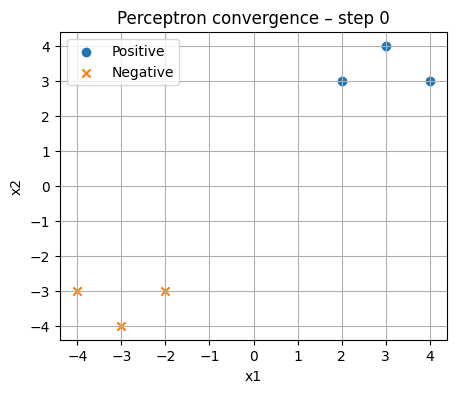

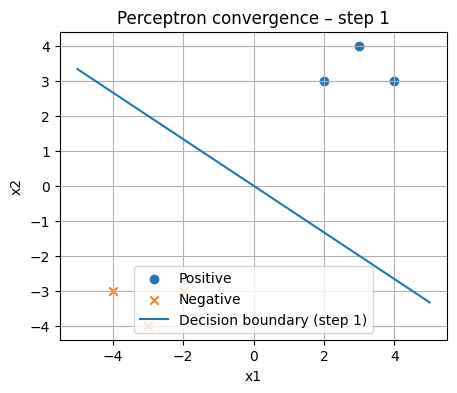

In [4]:
# Problem 5 – Visualizing Perceptron Convergence
#
# We construct a small, linearly separable 2D dataset with positive and
# negative examples, train a Perceptron, and plot the decision boundary
# after each update to show how it converges.

# Create a simple 2D dataset
X_pos = np.array([
    [2, 3],
    [3, 4],
    [4, 3],
])

X_neg = np.array([
    [-2, -3],
    [-3, -4],
    [-4, -3],
])

X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(len(X_pos)), -np.ones(len(X_neg))])  # +1 for positive, -1 for negative


def perceptron_train_with_history(X, y, lr=1.0, max_epochs=20):
    """
    Train a Perceptron and record the weight vector after each update.

    Parameters
    ----------
    X : array-like, shape (n_samples, 2)
        Input features.
    y : array-like, shape (n_samples,)
        Labels in {+1, -1}.
    lr : float
        Learning rate.
    max_epochs : int
        Maximum number of passes over the training set.

    Returns
    -------
    final_w : ndarray, shape (2,)
        Final weight vector.
    history : list of ndarray
        List of weight vectors after each update, including w_0.
    """
    w = np.zeros(2)
    history = [w.copy()]  # w_0

    for epoch in range(max_epochs):
        updated = False
        for x_i, y_i in zip(X, y):
            if y_i * np.dot(w, x_i) <= 0:
                w = w + lr * y_i * x_i
                history.append(w.copy())
                updated = True
        if not updated:
            break
    return w, history


def plot_decision_boundary(w, X_pos, X_neg, step_idx):
    """
    Plot the data points and the decision boundary for a given weight vector w.
    """
    plt.figure(figsize=(5, 4))

    # Plot positive and negative examples
    plt.scatter(X_pos[:, 0], X_pos[:, 1], marker="o", label="Positive")
    plt.scatter(X_neg[:, 0], X_neg[:, 1], marker="x", label="Negative")

    # Plot decision boundary: w1 * x1 + w2 * x2 = 0 => x2 = -(w1 / w2) * x1
    if not np.allclose(w, 0):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        xs = np.linspace(x_min, x_max, 100)
        if abs(w[1]) > 1e-8:
            ys = -(w[0] / w[1]) * xs
            plt.plot(xs, ys, label=f"Decision boundary (step {step_idx})")
        else:
            # Vertical line if w2 is zero
            plt.axvline(0.0, label=f"Decision boundary (step {step_idx})")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"Perceptron convergence – step {step_idx}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Train Perceptron and visualize convergence
final_w, w_history = perceptron_train_with_history(X, y, lr=1.0, max_epochs=20)

print("Final weight vector:", final_w)
print("Number of updates:", len(w_history) - 1)

for step_idx, w in enumerate(w_history):
    plot_decision_boundary(w, X_pos, X_neg, step_idx)
